<a href="https://colab.research.google.com/github/ade-femi/DSP/blob/Prediction-of-Depression-Severity-and-Personalised-Risk-Factors/Prediction%20of%20Depression%20Severity%20and%20Personalised%20Risk%20Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import chardet


In [ ]:
#check if GPU is provisioned
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#activate GPU
x = torch.randn(10, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)


In [ ]:
#merge datasets into three of twos as pd.merge can only merge two dataframes

# read in the demographics dataset
dmg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phm datasets/demographic.csv')

# read in the diet dataset
diet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phm datasets/diet.csv')

# read in the exam dataset
exam = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phm datasets/examination.csv')

# read in the lab dataset
labs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phm datasets/labs.csv')

medsdata = open('/content/drive/MyDrive/Colab Notebooks/phm datasets/medications.csv', 'rb').read()
result = chardet.detect(medsdata)
charenc = result['encoding']
print(charenc)

# read in the medications dataset
meds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phm datasets/medications.csv', encoding='ISO-8859-1')

# read in the questionnaire dataset
qstn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phm datasets/questionnaire.csv')

# merge datasets on the common variable SEQN which is the unique respondents sequence number
dprsn_df = pd.merge(dmg, diet, on='SEQN')
dprsn_df = pd.merge(dprsn_df, exam, on='SEQN')
dprsn_df = pd.merge(dprsn_df, labs, on='SEQN')
dprsn_df = pd.merge(dprsn_df, meds, on='SEQN')
dprsn_df = pd.merge(dprsn_df, qstn, on='SEQN')

# write the merged dataset to a new file
dprsn_df.to_csv('dprsn_dataset.csv', index=False)

print(dprsn_df)

ISO-8859-1
        SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0      73557         8         2         1        69       NaN         4   
1      73557         8         2         1        69       NaN         4   
2      73558         8         2         1        54       NaN         3   
3      73558         8         2         1        54       NaN         3   
4      73558         8         2         1        54       NaN         3   
...      ...       ...       ...       ...       ...       ...       ...   
19575  83727         8         2         1        26       NaN         2   
19576  83728         8         2         2         2      24.0         1   
19577  83729         8         2         2        42       NaN         4   
19578  83730         8         2         1         7       NaN         2   
19579  83731         8         2         1        11       NaN         5   

       RIDRETH3  RIDEXMON  RIDEXAGM  ...  WHD080U  WHD080L  WHD110  WHD120  

In [ ]:
# Check for duplicate SEQN values
duplicates = dprsn_df.duplicated(subset='SEQN', keep=False)

if duplicates.any():
    print("There are duplicate SEQN values in the dataset.")
else:
    print("All SEQN values are unique.")

There are duplicate SEQN values in the dataset.


In [ ]:
# store the SEQN column separately for identification purposes
patient_ids = dprsn_df['SEQN']

# drop the SEQN column from the dataset
dprsn_df.drop(columns=['SEQN'], inplace=True)

# Drop the column DPQ100
dprsn_df.drop(columns=['DPQ100'], inplace=True)


# Filter columns matching the regex '^DPQ\d{3}$'
dpq_cols = dprsn_df.filter(regex='^DPQ\d{3}$')

# Drop rows where any of the dpq_cols has values (7, 9, .), which are irrelavant responses and refusals to the questionnaire.
dpq_cols = dpq_cols[~dpq_cols.isin([7, 9, np.nan])]

# Sum the remaining columns '^DPQ\d{3}$' to a new column 'dqp_total'
dprsn_df['dqp_total'] = dpq_cols.sum(axis=1)

# Drop the columns used to create 'dqp_total'
dprsn_df.drop(columns=dpq_cols.columns, inplace=True)

In [ ]:
#Check for missing values
if dprsn_df.isnull().values.any():
  num_nan = dprsn_df.isnull().sum().sum()
  print(f"{num_nan} missing values found")

# Fill missing values with mean
  dprsn_df.fillna(dprsn_df.mean(), inplace=True)
  print("Missing values replaced with mean")

# Check for inconsistent values (e.g. negative ages)
if ('RIDAGEYR' in dprsn_df.columns) and ((dprsn_df['RIDAGEYR'] < 0) | (dprsn_df['RIDAGEMN'] < 0)).any():
    print("Inconsistent values found")
    # Remove rows with inconsistent values
    dprsn_df = dprsn_df[(dprsn_df['RIDAGEYR'] >= 0) & (dprsn_df['RIDAGEMN'] >= 0)]

#Check duplicated rows
if dprsn_df.duplicated().any():
  print("Duplicate rows found")
  # Drop duplicated rows
  dprsn_df.drop_duplicates(inplace=True)

#Convert categorical variables to dummy variables
dprsn_df_cat = pd.get_dummies(dprsn_df)

# Convert scaled data back to pandasDF
dprsnscaleddf = pd.DataFrame(dprsn_df_cat, columns=dprsn_df.columns)

# get the list of columns with NaN values
nan_cols = dprsnscaleddf.columns[dprsnscaleddf.isna().any()].tolist()

# print the list of columns with NaN values
print("Columns with NaN values:", nan_cols)
for col in nan_cols:
    print(f"Column '{col}' has {dprsnscaleddf[col].isna().sum()} NaN values.")
    print("Description: ", dprsnscaleddf[col].describe())
    print("Number of NaN values: ", dprsnscaleddf[col].isna().sum())

#Description of columns with nan values shows they all contain only Nan values, we drop them as FS algorithm won't take in nan values.
dprsn = dprsnscaleddf.drop(columns=nan_cols)

21696865 missing values found


<ipython-input-7-39363fb53808>:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dprsn_df.fillna(dprsn_df.mean(), inplace=True)


Missing values replaced with mean
Duplicate rows found
Columns with NaN values: ['DRQSDT5', 'BMIHEAD', 'OHX02CTC', 'OHX03CTC', 'OHX04CTC', 'OHX05CTC', 'OHX06CTC', 'OHX07CTC', 'OHX08CTC', 'OHX09CTC', 'OHX10CTC', 'OHX11CTC', 'OHX12CTC', 'OHX13CTC', 'OHX14CTC', 'OHX15CTC', 'OHX18CTC', 'OHX19CTC', 'OHX20CTC', 'OHX21CTC', 'OHX22CTC', 'OHX23CTC', 'OHX24CTC', 'OHX25CTC', 'OHX26CTC', 'OHX27CTC', 'OHX28CTC', 'OHX29CTC', 'OHX30CTC', 'OHX31CTC', 'CSXTSEQ', 'RXDDRUG', 'RXDDRGID', 'RXDRSC1', 'RXDRSC2', 'RXDRSC3', 'RXDRSD1', 'RXDRSD2', 'RXDRSD3', 'MCQ240I', 'MCQ240R', 'MCQ240V', 'SMDUPCA', 'SMD100BR', 'SMQ690J', 'SMQ861']
Column 'DRQSDT5' has 19560 NaN values.
Description:  count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: DRQSDT5, dtype: float64
Number of NaN values:  19560
Column 'BMIHEAD' has 19560 NaN values.
Description:  count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: BMIHE

In [ ]:
print(dprsn)

       SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR   RIDAGEMN  RIDRETH1  RIDRETH3  \
0             8         2         1        69  10.347633         4         4   
1             8         2         1        69  10.347633         4         4   
2             8         2         1        54  10.347633         3         3   
3             8         2         1        54  10.347633         3         3   
4             8         2         1        54  10.347633         3         3   
...         ...       ...       ...       ...        ...       ...       ...   
19575         8         2         1        26  10.347633         2         2   
19576         8         2         2         2  24.000000         1         1   
19577         8         2         2        42  10.347633         4         4   
19578         8         2         1         7  10.347633         2         2   
19579         8         2         1        11  10.347633         5         6   

       RIDEXMON    RIDEXAGM  DMQMILIZ  

In [ ]:
# Separate the features, target variable
X = dprsn.drop(['dqp_total'], axis=1)
y = dprsn['dqp_total']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train)
print(X_test)

       SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR   RIDAGEMN  RIDRETH1  RIDRETH3  \
3120          8         2         1        80  10.347633         3         3   
15352         8         2         1        60  10.347633         3         3   
3232          8         2         1        56  10.347633         4         4   
7684          8         2         1        64  10.347633         3         3   
4710          8         2         2        40  10.347633         2         2   
...         ...       ...       ...       ...        ...       ...       ...   
1936          8         2         1        72  10.347633         4         4   
6083          8         2         1        52  10.347633         5         7   
1989          8         2         2        55  10.347633         5         6   
2756          8         2         2        66  10.347633         5         6   
2372          8         2         1        66  10.347633         3         3   

       RIDEXMON    RIDEXAGM  DMQMILIZ  

In [ ]:
# Cross-Validation of SelectKBest
# Define the range of k values to try
k_values = [50, 100, 150, 200, 250, 300]

# Create an instance of SelectKBest with f_regression as the score function
selector = SelectKBest(f_regression)

# Create an instance of RandomForestRegressor
estimator = RandomForestRegressor()

# Create an instance of KFold with 5 splits
kf = KFold(n_splits=5)

# Initialize an empty list to store the average scores for each k value
scores = []


# Convert the DataFrame to a numpy array
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

# Loop over the k values
for k in k_values:
    # Set the k parameter for the selector
    selector.set_params(k=k)

    # Initialize an empty list to store the scores for each fold
    fold_scores = []

    # Loop over the folds
    for train_index, test_index in kf.split(X_train):
        # Split the data into train and test sets using the fold indices
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Fit the selector on the train set and transform both sets using the selected features
        X_train_fold = selector.fit_transform(X_train_fold, y_train_fold)
        X_test_fold = selector.transform(X_test_fold)

        # Fit the estimator on the train set and predict on the test set
        estimator.fit(X_train_fold, y_train_fold)
        y_pred_fold = estimator.predict(X_test_fold)

        # Compute and append the r2 score for the fold
        fold_score = r2_score(y_test_fold, y_pred_fold)
        fold_scores.append(fold_score)

    # Compute and append the average score for the k value
    score = sum(fold_scores) / len(fold_scores)
    scores.append(score)

# Find the index of the best score
best_index = scores.index(max(scores))

# Print the best k value and score
print(k_values[best_index])
print(scores[best_index])

# Set the k parameter for the selector to the best value
selector.set_params(k=k_values[best_index])

# Fit the selector on the whole training set and transform both sets using the best k features
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)


300
0.8915930767062722


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


In [ ]:
# Normalize the data using MinMaxScaler
normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
#For consistency between the training and test sets, the same scaling parameters used to normalise the training set is also be applied to scale the test set.
#This helps ensure that the model is not biased towards any particular set of data and can generalize well to new data
X_test = normalizer.transform(X_test)

Develop a LR, SVM, XGB, RF and LASSO and apply on the data


In [ ]:
# Create a random forest regressor model
RMmodel = RandomForestRegressor(n_estimators=100, random_state=100)
RMmodel.fit(X_train, y_train)
RMmodel_pred = RMmodel.predict(X_test)
print(RMmodel_pred)

[1.9  4.16 0.68 ... 2.09 0.   2.81]


In [ ]:
# Evaluation of the randomforestregressor model

# Evaluate the model using mean squared error
RF_mse = mean_squared_error(y_test, RMmodel_pred)
print("RF Mean Squared Error: ", round(RF_mse, 2))

# Calculate R-squared
RF_r2 = r2_score(y_test, RMmodel_pred)
print("RF R-Squared: ", round(RF_r2, 2))

# Calculate RMSE
RF_rmse = mean_squared_error(y_test, RMmodel_pred, squared=False)
print("RF Root Mean Squared Error: ", round(RF_rmse, 2))

# calculate mae
RF_mae = mean_absolute_error(y_test, RMmodel_pred)
print("RF Mean Absolute Error: ", round(RF_mae, 2))

# calculate evs
RF_evs = explained_variance_score(y_test, RMmodel_pred)
print("RF Explained Variance Score: ", round(RF_evs, 2))

RF Mean Squared Error:  1.73
RF R-Squared:  0.93
RF Root Mean Squared Error:  1.32
RF Mean Absolute Error:  0.51
RF Explained Variance Score:  0.93


In [ ]:
#Create a Lasso Lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print(lasso_pred)

[1.00908746 2.00100413 0.93786913 ... 7.53384094 1.33190841 4.07030738]


In [ ]:
# Evaluation of the Lasso regressor model

# Evaluate the model using mean squared error
lasso_mse = round(mean_squared_error(y_test, lasso_pred), 2)
print("Lasso Mean Squared Error: ", lasso_mse)

# Calculate R-squared
lasso_r2 = round(r2_score(y_test, lasso_pred), 2)
print("Lasso R-Squared: ", lasso_r2)

# Calculate RMSE
lasso_rmse = round(mean_squared_error(y_test, lasso_pred, squared=False), 2)
print("Lasso Root Mean Squared Error: ", lasso_rmse)

# calculate MAE
lasso_mae = round(mean_absolute_error(y_test, lasso_pred), 2)
print("Lasso Mean Absolute Error: ", lasso_mae)

# calculate EVS
lasso_evs = round(explained_variance_score(y_test, lasso_pred), 2)
print("Lasso Explained Variance Score: ", lasso_evs)


Lasso Mean Squared Error:  1092.03
Lasso R-Squared:  -44.1
Lasso Root Mean Squared Error:  33.05
Lasso Mean Absolute Error:  3.34
Lasso Explained Variance Score:  -44.09


In [ ]:
#Create a SVM regression model
svm = SVR(kernel='rbf')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print(svm_pred)

[ 0.86572948  1.63272535 -0.79580296 ...  4.39148817 -0.11702047
  0.48177815]


In [ ]:
#Evaluation of the SVM model

# Evaluate the model using mean squared error
svm_mse = round(mean_squared_error(y_test, svm_pred), 2)
print("SVM Mean Squared Error: ", svm_mse)

# Calculate R-squared
svm_r2 = round(r2_score(y_test, svm_pred), 2)
print("SVM R-Squared: ", svm_r2)

# Calculate RMSE
svm_rmse = round(mean_squared_error(y_test, svm_pred, squared=False), 2)
print("SVM Root Mean Squared Error: ", svm_rmse)

#calculate mae
svm_mae = round(mean_absolute_error(y_test, svm_pred), 2)
print("SVM Mean Absolute Error: ", svm_mae)

#calculate evs
svm_evs = round(explained_variance_score(y_test, svm_pred), 2)
print("SVM Explained Variance Score: ", svm_evs)

SVM Mean Squared Error:  11.7
SVM R-Squared:  0.52
SVM Root Mean Squared Error:  3.42
SVM Mean Absolute Error:  1.87
SVM Explained Variance Score:  0.54


In [ ]:
#Create a  Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(lr_pred)

[-0.00488281  3.29492188 -3.26074219 ...  4.796875    0.59667969
  0.79589844]


In [ ]:
# Evaluation of the Linearregressor model

# Evaluate the model using mean squared error
LR_mse = mean_squared_error(y_test, lr_pred)
print("LR Mean Squared Error: ", round(LR_mse, 2))

# Calculate R-squared
LR_r2 = r2_score(y_test, lr_pred)
print("LR R-Squared: ", round(LR_r2, 2))

# Calculate RMSE
LR_rmse = mean_squared_error(y_test, lr_pred, squared=False)
print("LR Root Mean Squared Error: ", round(LR_rmse, 2))

# calculate mae
LR_mae = mean_absolute_error(y_test, lr_pred)
print("LR Mean Absolute Error: ", round(LR_mae, 2))

# calculate evs
LR_evs = explained_variance_score(y_test, lr_pred)
print("LR Explained Variance Score: ", round(LR_evs, 2))


LR Mean Squared Error:  1437.86
LR R-Squared:  -58.39
LR Root Mean Squared Error:  37.92
LR Mean Absolute Error:  2.95
LR Explained Variance Score:  -58.37


In [ ]:
#Create a XGBoost Regression model#
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print(xgb_pred)

[ 1.7872536   3.6414497   0.40808707 ...  2.6622171  -0.10786943
  0.5698614 ]


In [ ]:
#Evaluation of XGBOOSTregressor developed model

# Evaluate the model using mean squared error
XGB_mse = mean_squared_error(y_test, xgb_pred)
print("XGB Mean Squared Error: ", round(XGB_mse, 2))

# Calculate R-squared
XGB_r2 = r2_score(y_test, xgb_pred)
print("XGB R-Squared: ", round(XGB_r2, 2))

# Calculate RMSE
XGB_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
print("XGB Root Mean Squared Error: ", round(XGB_rmse, 2))

#calculate mae
XGB_mae = mean_absolute_error(y_test, xgb_pred)
print("XGB Mean Absolute Error: ", round(XGB_mae, 2))

#calculate evs
XGB_evs = explained_variance_score(y_test, xgb_pred)
print("XGB Explained Variance Score: ", round(XGB_evs, 2))


XGB Mean Squared Error:  2.28
XGB R-Squared:  0.91
XGB Root Mean Squared Error:  1.51
XGB Mean Absolute Error:  0.75
XGB Explained Variance Score:  0.91


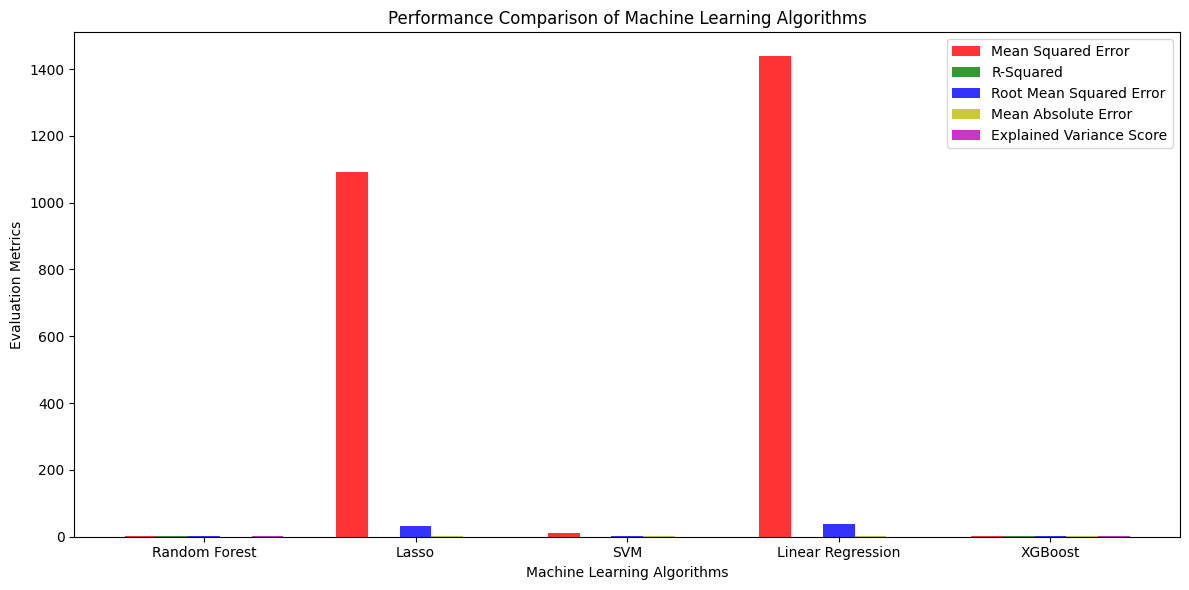

In [ ]:
# Define the model names and evaluation metrics
Algorithms = ['Random Forest', 'Lasso', 'SVM', 'Linear Regression', 'XGBoost']
mse = [RF_mse, lasso_mse, svm_mse, LR_mse, XGB_mse]
r2 = [RF_r2, lasso_r2, svm_r2, LR_r2, XGB_r2]
rmse = [RF_rmse, lasso_rmse, svm_rmse, LR_rmse, XGB_rmse]
mae = [RF_mae, lasso_mae, svm_mae, LR_mae, XGB_mae]
evs = [RF_evs, lasso_evs, svm_evs, LR_evs, XGB_evs]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(len(Algorithms))
bar_width = 0.15
opacity = 0.8

rects1 = ax.bar(index, mse, bar_width, alpha=opacity, color='r', label='Mean Squared Error')
rects2 = ax.bar(index + bar_width, r2, bar_width, alpha=opacity, color='g', label='R-Squared')
rects3 = ax.bar(index + 2*bar_width, rmse, bar_width, alpha=opacity, color='b', label='Root Mean Squared Error')
rects4 = ax.bar(index + 3*bar_width, mae, bar_width, alpha=opacity, color='y', label='Mean Absolute Error')
rects5 = ax.bar(index + 4*bar_width, evs, bar_width, alpha=opacity, color='m', label='Explained Variance Score')

ax.set_xlabel('Machine Learning Algorithms')
ax.set_ylabel('Evaluation Metrics')
ax.set_title('Performance Comparison of Machine Learning Algorithms')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(Algorithms)
ax.legend()

# Set y-axis limits
margin = 0.05 * max(mse + r2 + rmse + mae + evs)
ax.set_ylim([0, max(mse + r2 + rmse + mae + evs) + margin])

plt.tight_layout()
plt.show()


Going forward, I will be working with best performing model in predicting severity and personalised risk factors

Index(['DR1TP204', 'MGXH1T2E', 'DRD370EQ', 'BMXBMI', 'BMDAVSAD', 'MGQ100',
       'RIDSTATR', 'BMXHEAD', 'DMDHSEDU', 'DRD350F', 'DMDFMSIZ', 'MIALANG',
       'FIAPROXY', 'BPXDI2', 'OHDEXSTS', 'OHX06TC', 'DR1TFF', 'DRD370NQ',
       'WTMEC2YR', 'DR1TSUGR', 'FIAINTRP', 'DR1TVK', 'BPXDI4', 'DMQADFC',
       'INDHHIN2', 'DR1TCRYP', 'DR1TFA', 'DR1TFDFE', 'DR1TM201', 'DR1TCARB',
       'MIAINTRP', 'DR1TIRON', 'DR1TCHL', 'DRD370OQ', 'DRD350FQ', 'DR1TFOLA',
       'WTINT2YR', 'DRD370BQ', 'DR1TWS', 'SIALANG', 'DR1TB12A', 'OHX12TC',
       'DR1TLZ', 'MIAPROXY', 'MGQ110', 'DR1TVC', 'DMDHREDU', 'DMDHHSZE',
       'BMIARML', 'DMDHRMAR'],
      dtype='object')


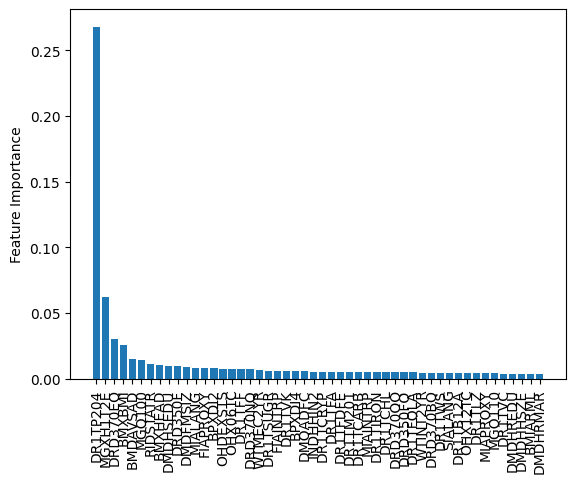

In [ ]:
# Get feature importances and plot them
rand_feature_importances = RMmodel.feature_importances_
feature_names = X.columns

# extract the indices of the most important features
important_feature_indices = np.argsort(rand_feature_importances)[::-1][:50]
important_feature_names = feature_names[important_feature_indices]
print(important_feature_names)

plt.bar(important_feature_names, rand_feature_importances[important_feature_indices])
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")
plt.show()

In [ ]:
#Generate personalised Modifiable risk factors
# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test)

# Classify predicted severity based on PHQ-9 scale
for i, pred in enumerate(RMmodel_pred):
    patient_id = patient_ids[X_test_df.index[i]]
    print(f"For patient {patient_id}:")

    if pred < 5:
        print("Depression severity: Minimal or none")
    elif pred < 10:
        print("Depression severity: Mild")
    elif pred < 15:
        print("Depression severity: Moderate")
    elif pred < 20:
        print("Depression severity: Moderately Severe")
    else:
        print("Depression severity: Severe")


# Identify Personalised risk factors for patients in the dataset
for i, idx in enumerate(X_test_df.index[:5]):
    patient_id = patient_ids[idx]
    print(f"For patient {patient_id}:")
    important_features = X_test_df.iloc[i][important_feature_indices]
    important_modifiable_risk_factors = important_feature_names[important_features > 0]
    print("The personalised risk factors in order of importance are:", important_modifiable_risk_factors)


Streaming output truncated to the last 5000 lines.
Depression severity: Minimal or none
For patient 74254:
Depression severity: Minimal or none
For patient 74254:
Depression severity: Minimal or none
For patient 74254:
Depression severity: Minimal or none
For patient 74255:
Depression severity: Mild
For patient 74256:
Depression severity: Minimal or none
For patient 74257:
Depression severity: Minimal or none
For patient 74258:
Depression severity: Minimal or none
For patient 74259:
Depression severity: Moderately Severe
For patient 74260:
Depression severity: Minimal or none
For patient 74260:
Depression severity: Mild
For patient 74261:
Depression severity: Minimal or none
For patient 74262:
Depression severity: Minimal or none
For patient 74262:
Depression severity: Minimal or none
For patient 74262:
Depression severity: Moderate
For patient 74262:
Depression severity: Mild
For patient 74262:
Depression severity: Minimal or none
For patient 74262:
Depression severity: Minimal or non

P.S.     Patient ID occurs multiple times because they had multiple rows in the original dataset, as they participated in multiple NHANES cycles or had multiple measurements taken.


In [ ]:
!pip3 install nbconvert
!jupyter nbconvert --to html prediction_of_depression_severity_and_personalised_risk_factors_on_nhanes.ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[NbConvertApp] Converting notebook prediction_of_depression_severity_and_personalised_risk_factors_on_nhanes.ipynb to html
[NbConvertApp] Writing 947519 bytes to prediction_of_depression_severity_and_personalised_risk_factors_on_nhanes.html
